<img src="vanilla_gan.png">

In [34]:
# adaptod from https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid, save_image

import imageio
import numpy as np
import matplotlib   # plotting purposes


from matplotlib import pyplot as plt

matplotlib.style.use('ggplot')

class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 1, 28, 28)   # Bx1x28x28

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),   #784 is MNIST input feature dimension
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 1),      # single value stating fake or real
            nn.Sigmoid()            # value between 0 and 1
        )
    def forward(self, x):
        x = x.view(-1, 784)         # reshape input same as torch.flatten(x, start_dim=1)
        return self.model(x)

In [35]:
# torch parameters
SEED = 60            # reproducability
# NN Parameters
EPOCHS = 300         # number of epochs
LR = 0.0002          # learning rate
MOMENTUM = 0.9       # momentum for the optimizer
WEIGHT_DECAY = 1e-5  # weight decay for the optimizer
GAMMA = 0.1          # learning rate schedular
BATCH_SIZE = 512     # number of images to load per iteration
# GAN parameters
SAMPLE_SIZE = 64     # number of fake images to sample
LATENT_SIZE = 128    # size of latent or noise vector
DISC_STEPS  = 1      # number of steps to apply to the discriminator

# manual seed to reproduce same results
torch.manual_seed(SEED)

# DOWNLOADING AND LOADING MNIST DATASET 
mnist_folder= './data'

# normalize each image and set the pixel values between -1 and 1
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

to_pil_image = transforms.ToPILImage()

# download the dataset if not already downloaded and set necessery transforms
tr_dataset   = MNIST(mnist_folder, train=True, download=True, transform=img_transform)
# prepare loader for the training dataset
train_loader = torch.utils.data.DataLoader(tr_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

# determine where to run the code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# create the generator network and move to gpu if available
gen_net = Generator(LATENT_SIZE).to(device)
# create the discriminator and move to gpu if available
disc_net = Discriminator().to(device)

# specify the loss to be used
# Binary Cross Entropy Loss
loss_fn = nn.BCELoss()
# specify the optimizer for generator network
optimizer_gen = optim.Adam(gen_net.parameters(), lr=LR)
# specify the optimizer for discriminator network
optimizer_disc = optim.Adam(disc_net.parameters(), lr=LR)

# function to create the noise vector
def create_noise(batch_size):
    return torch.randn(batch_size, LATENT_SIZE).to(device)


def train_discriminator(real_x, fake_x):
    B = real_x.size(0)                         # batch size
    real_y = torch.ones(B, 1).to(device)       # create labels of 1
    fake_y = torch.zeros(B, 1).to(device)      # create labels of 0
    
    optimizer_disc.zero_grad()
    # forward pass the real data
    output_real = disc_net(real_x)
    # estimate loss         
    loss_real = loss_fn(output_real, real_y)
    # forward pass the fake data
    output_fake = disc_net(fake_x)
    # estimate loss
    loss_fake = loss_fn(output_fake, fake_y)
    # accumulate gradients for both passes 
    loss_real.backward()
    loss_fake.backward()
    # update weights of discriminator
    optimizer_disc.step()
    return loss_real.item() + loss_fake.item()

# update generator weights using the gradients of discriminator
def train_generator(fake_x):
    B = fake_x.size(0)                       # batch size
    real_y = torch.ones(B, 1).to(device)     # create labels of 1

    optimizer_gen.zero_grad()
    # forward pass the fake data on discriminator
    output = disc_net(fake_x)
    # determine how far we are from real label
    loss = loss_fn(output, real_y)
    # calculate gradients
    loss.backward()
    # update generator weights
    optimizer_gen.step()
    return loss.item()


In [36]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

0
Generator loss: 3.85858297, Discriminator loss: 0.28020233
Epoch 37 of 300
Generator loss: 3.49907207, Discriminator loss: 0.35612983
Epoch 38 of 300
Generator loss: 3.56890559, Discriminator loss: 0.32570240
Epoch 39 of 300
Generator loss: 3.41493392, Discriminator loss: 0.39599916
Epoch 40 of 300
Generator loss: 3.28369784, Discriminator loss: 0.36247644
Epoch 41 of 300
Generator loss: 3.34817052, Discriminator loss: 0.34540918
Epoch 42 of 300
Generator loss: 3.14941621, Discriminator loss: 0.38168967
Epoch 43 of 300
Generator loss: 3.04987550, Discriminator loss: 0.38107479
Epoch 44 of 300
Generator loss: 2.95842695, Discriminator loss: 0.40814742
Epoch 45 of 300
Generator loss: 3.03955078, Discriminator loss: 0.39038312
Epoch 46 of 300
Generator loss: 2.97063875, Discriminator loss: 0.41950738
Epoch 47 of 300
Generator loss: 3.05880046, Discriminator loss: 0.43588302
Epoch 48 of 300
Generator loss: 2.89793825, Discriminator loss: 0.45019102
Epoch 49 of 300
Generator loss: 2.75017

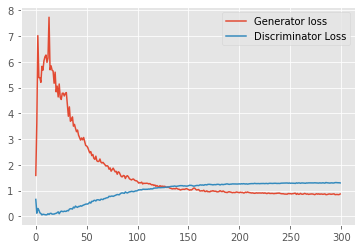

In [37]:
losses_g = [] # store generator loss after each epoch
losses_d = [] # store discriminator loss after each epoch
images = []   # store images generatd by the generator


# create the noise vector
noise = create_noise(SAMPLE_SIZE)
# put the networks in training mode
gen_net.train()
disc_net.train()

for epoch in range(EPOCHS):
    loss_g = 0.0
    loss_d = 0.0
    for idx, (img, _) in enumerate(train_loader):
        # move image to gpu if exists
        img = img.to(device)
        # get batch size
        b_size = len(img)
        # run the discriminator for DISC_STEPS number of steps
        for _ in range(DISC_STEPS):
            fake_x = gen_net(create_noise(b_size)).detach()
            real_x = img
            # train the discriminator network
            loss_d += train_discriminator(real_x, fake_x)
        fake_x = gen_net(create_noise(b_size))
        # train the generator network
        loss_g += train_generator(fake_x)
    # create the final fake image for the epoch
    generated_img = gen_net(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"gan_outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx # total generator loss for the epoch
    epoch_loss_d = loss_d / idx # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {EPOCHS}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
torch.save(gen_net.state_dict(), 'gan_outputs/generator.pth')
torch.save(disc_net.state_dict(), 'gan_outputs/discriminator.pth')

# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('gan_outputs/generator_images.gif', imgs)

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('gan_outputs/loss.png')